In [7]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted

class MultinomialSyntheticDataGenerator(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=None):
        """
        A custom estimator for generating synthetic data using multinomial logistic regression,
        with the feature distribution inferred from the training data.
        
        Parameters:
        - n_samples (int): Number of synthetic samples to generate.
        - random_state (int): Seed for reproducibility.
        """
        self.random_state = random_state
        np.random.seed(self.random_state)


    def fit(self, X, y):
        """
        Fits a multinomial logistic regression model to the data and estimates the feature distribution.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        - y (ndarray): Target labels of shape (n_samples,).
        
        Returns:
        - self: The fitted instance.
        """
        # Store mean and covariance of features
        self.classes_ = np.unique(y)
        self.feature_mean_ = np.mean(X, axis=0)
        self.feature_cov_ = np.cov(X, rowvar=False)
        
        # Fit a logistic regression model
        self.model_ = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=self.random_state)
        self.model_.fit(X, y)
        
        # Store the number of classes and features
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        return self

    def predict_proba(self, X):
        """
        Predicts class probabilities for the given feature matrix.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        
        Returns:
        - probabilities (ndarray): Predicted probabilities of shape (n_samples, n_classes).
        """
        check_is_fitted(self, "model_")
        return self.model_.predict_proba(X)
    

    def predict(self, X):
        """
        Predicts class probabilities for the given feature matrix.
        
        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        
        Returns:
        - probabilities (ndarray): Predicted probabilities of shape (n_samples, n_classes).
        """
        check_is_fitted(self, "model_")
        return self.model_.predict(X)

    def generate(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        check_is_fitted(self, ["model_", "feature_mean_", "feature_cov_"])
        
        # Generate synthetic features based on the inferred distribution
        X_synthetic = np.random.multivariate_normal(self.feature_mean_, self.feature_cov_, n)
        
        # Compute class probabilities
        P_Y_given_X = self.predict_proba(X_synthetic)
        
        # Sample synthetic labels
        y_synthetic = np.array([np.random.choice(self.n_classes_, p=probs) for probs in P_Y_given_X])
        
        return X_synthetic, y_synthetic


    def generate_instances(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """
        check_is_fitted(self, ["model_", "feature_mean_", "feature_cov_"])
        
        # Generate synthetic features based on the inferred distribution
        
        X = np.random.multivariate_normal(self.feature_mean_, self.feature_cov_, n)
        return X



In [8]:
class OracleAnnotator:
    def __init__(self,mapie_clf, generator):
        self.mapie_clf = mapie_clf
        self.classes_ = mapie_clf.classes_
        self.generator = generator

    def generate_pairs_in_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        X = self.generator.generate_instances(n)
        X = np.repeat(X, repeats=2, axis=0)

        y = np.hstack([np.random.choice(self.classes_, size=2, replace=False) for _ in range(n)])

        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)
        return X_pairs, y_pairs


    def generate_pairs_cross_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        
        X = self.generator.generate_instances(2*n)
        y = np.random.choice(self.classes_, size=2*n, replace=True)
        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)

        return X_pairs, y_pairs


    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.mapie_clf.estimator.predict_proba(X)
        scores = self.mapie_clf.conformity_score_function_.get_conformity_scores(
                        y, y_pred_proba, y_enc=y
                    )
        return scores

In [9]:
from mapie.classification import MapieClassifier
from mapie.conformity_scores.sets import APSConformityScore, LACConformityScore, NaiveConformityScore
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from sklearn.datasets import make_classification
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

def conduct_oracle_experiment(conformity_score, num_pairs_to_check):
    tau_corrs = []
    # Generate a small dataset
    X_train, y_train = make_classification(
        n_samples=10000, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, random_state=42
    )

    # Initialize and fit the generator
    generator = MultinomialSyntheticDataGenerator(random_state=42)
    generator.fit(X_train, y_train)
    X_cal, y_cal = generator.generate(n=100)
    mapie_clf = MapieClassifier(estimator=generator, cv="prefit", conformity_score=conformity_score)
    # create mapie classifier for conformity scores
    mapie_clf.fit(X_cal, y_cal)
    # create 
    oracle_annotator = OracleAnnotator(mapie_clf, generator)

    for num_pairs in num_pairs_to_check:
        X_pairs, y_pairs = oracle_annotator.generate_pairs_cross_instance(num_pairs)
        ds = LabelPairDataset()
        ds.create_from_numpy_pairs(X_pairs, y_pairs)
        model = LabelRankingModel(input_dim=X_train.shape[1], hidden_dim=X_train.shape[1], output_dim=len(generator.classes_))
        pair_loader = DataLoader(ds, batch_size=64)
        model.num_classes = generator.n_classes_
        model._fit(pair_loader, val_loader=None, num_epochs=200, learning_rate=0.01)


        # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
        X_test, y_test = generator.generate(n=100)
        skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1) 
        conformity_scores = oracle_annotator.get_conformity(X_test, y_test)
        tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
        tau_corrs.append(tau_corr)
    return tau_corrs

In [ ]:
num_pairs_to_check = np.linspace(2**5,2**14,5).astype(int)
tau_corrs_LAC = conduct_oracle_experiment(LACConformityScore(), num_pairs_to_check)
tau_corrs_APS = conduct_oracle_experiment(APSConformityScore(), num_pairs_to_check)


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<Axes: title={'center': 'APS'}, xlabel='No. Pairs', ylabel='Kendalls $\\tau$'>

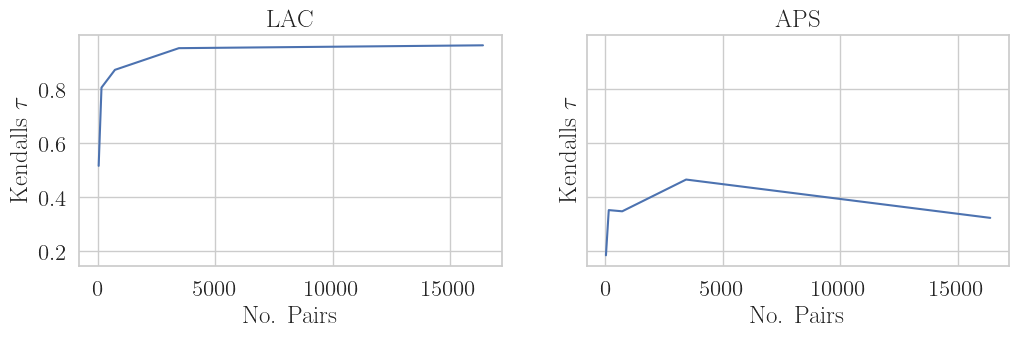

In [11]:
from turtle import title
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (12, 3)


fig, axes = plt.subplots(1,2, sharey=True)
axes = axes.ravel()

axes[0].set_title("LAC")
axes[0].set_ylabel(r"Kendalls $\tau$")
axes[0].set_xlabel(r"No. Pairs")
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_LAC, ax = axes[0])
axes[1].set_title("APS")
axes[1].set_ylabel(r"Kendalls $\tau$")
axes[1].set_xlabel(r"No. Pairs")
sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])